<a href="https://colab.research.google.com/github/ygsriram/hrs/blob/main/Profanity_%26_Hate_Speech_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Profanity & Hate Speech Detector

In this notebook, we will be looking at how create a Profanity & Hate Speech Detector and also how to create a TensorFlow Lite model that can be used in the development of an Android Application to curb Profanity & Hateful Speeches.

# Data Analysis and Preprocessing

### Importing required libraries for data  analysis and preprocessing 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
%matplotlib inline

### Please find the data [here](https://drive.google.com/file/d/1-4goFIBsUrml0QZaPTWINyxeKzj04TLf/view?usp=sharing) 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_excel("/content/drive/MyDrive/Datasets/data.xlsx")

### This dataset contains the twitter extracted posts where, each post in the dataset is annotated from three different perspectives: the basic, commonly used 3-class classification (i.e., hate, offensive or normal), the target community (i.e., the community that has been the victim of hate speech/offensive speech in the post), and the rationales, i.e., the portions of the post on which their labelling decision (as hate, offensive or normal) is based. 

### To learn more about the dataset please refer [this](https://github.com/punyajoy/HateXplain) 

@article{mathew2020hatexplain,

  title={HateXplain: A Benchmark Dataset for Explainable Hate Speech Detection},

  author={Mathew, Binny and Saha, Punyajoy and Yimam, Seid Muhie and Biemann, Chris and Goyal, Pawan and Mukherjee, Animesh},

  journal={arXiv preprint arXiv:2012.10289},
  
  year={2020}
}

In [4]:
df.head()

,post_id,text,annotatorid1,target1,label1,annotatorid2,target2,label2,annotatorid3,target3,label3,rationales,final_label
0,1179055004553900032_twitter,"['i', 'dont', 'think', 'im', 'getting', 'my', ...",1,['None'],normal,2,['None'],normal,3,['None'],normal,[],non-toxic
1,1179063826874032128_twitter,"['we', 'cannot', 'continue', 'calling', 'ourse...",1,['None'],normal,2,['None'],normal,3,['None'],normal,[],non-toxic
2,1178793830532956161_twitter,"['nawt', 'yall', 'niggers', 'ignoring', 'me']",4,['African'],normal,2,['None'],normal,3,['African'],hatespeech,[],non-toxic
3,1179088797964763136_twitter,"['<user>', 'i', 'am', 'bit', 'confused', 'coz'...",1,['Asian'],hatespeech,4,['Asian'],offensive,3,['Asian'],hatespeech,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",toxic
4,1179085312976445440_twitter,"['this', 'bitch', 'in', 'whataburger', 'eating...",4,"['Caucasian', 'Women']",hatespeech,2,"['Women', 'Caucasian']",hatespeech,3,"['Women', 'Caucasian']",offensive,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",toxic


### This dataframe contains final lable column that can be used in order to indentify whether the post is ["toxi", "non-toxic", "undecided"] and the distrubition for each of them is shown below

<BarContainer object of 3 artists>

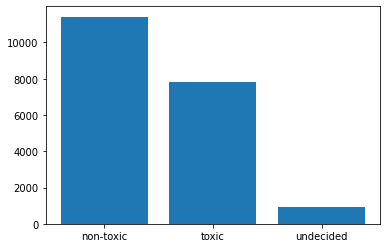

In [5]:
plt.bar(df.final_label.unique(),  df.final_label.value_counts().values)

<BarContainer object of 3 artists>

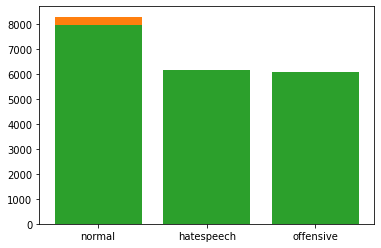

In [6]:
plt.bar(df.label1.unique(),  df.label1.value_counts().values)
plt.bar(df.label2.unique(),  df.label2.value_counts().values)
plt.bar(df.label3.unique(),  df.label3.value_counts().values)

### Below we have the posts distribution based on the target community (i.e., the community that has been the victim of hate speech/offensive speech in the post)

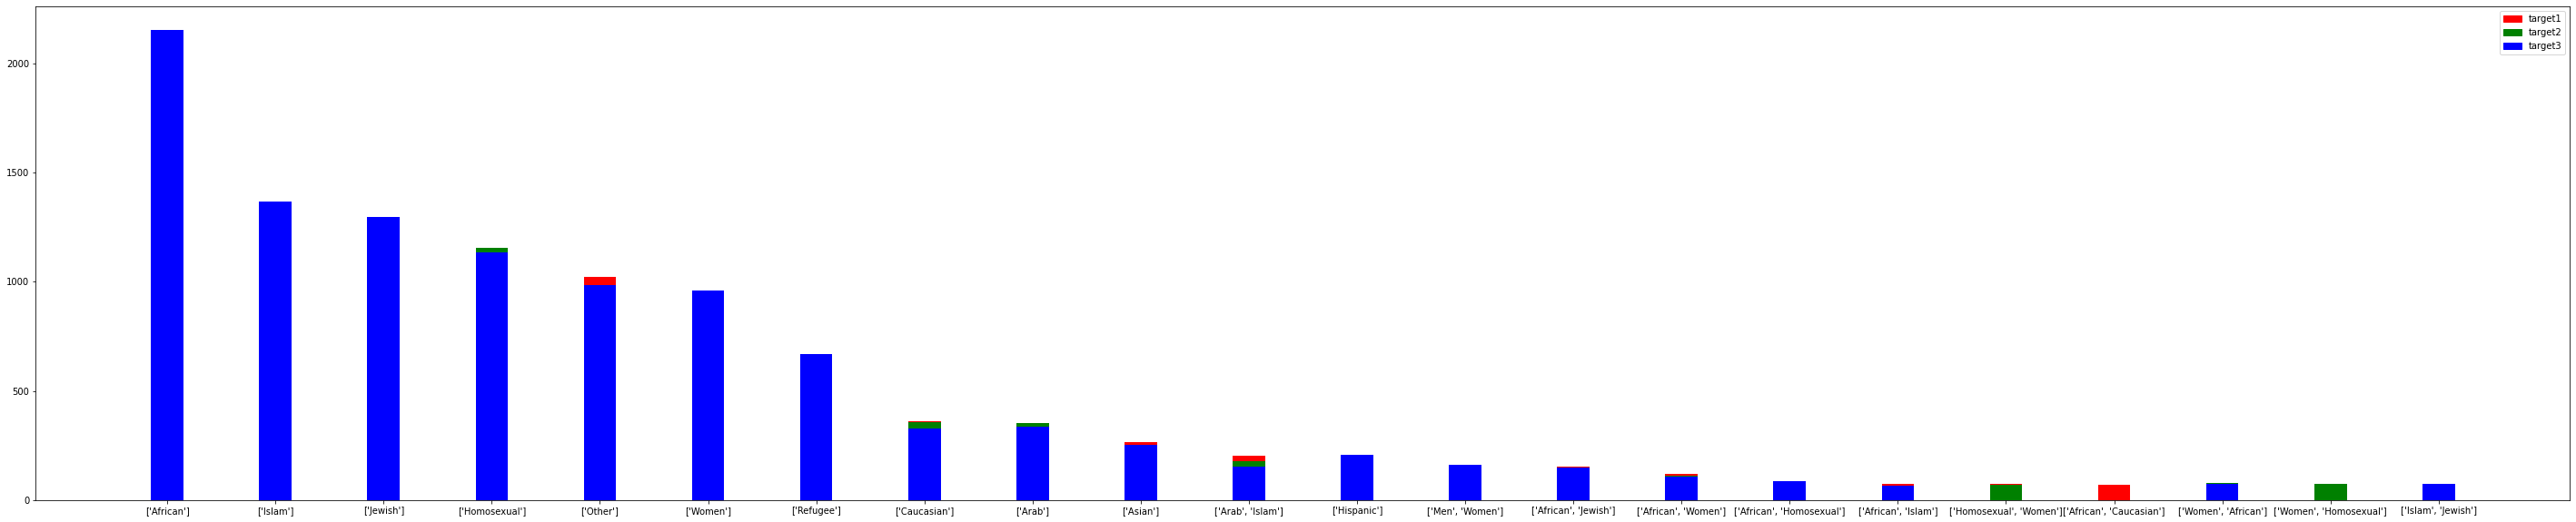

In [7]:
plt.figure(figsize = (50,10))

plt.bar(df.target1.value_counts().keys()[1:20],  df.target1.value_counts().values[1:20],color="red", width = .3)
plt.bar(df.target2.value_counts().keys()[1:20],  df.target2.value_counts().values[1:20],color="green", width = .3)
plt.bar(df.target3.value_counts().keys()[1:20],  df.target3.value_counts().values[1:20],color="blue", width = .3)
red_patch = mpatches.Patch(color='red', label='target1')
green_patch = mpatches.Patch(color='green', label='target2')
blue_patch = mpatches.Patch(color='blue', label='target3')
plt.legend(handles=[red_patch, green_patch, blue_patch])

### As we can see from the distribution the African, Islam, Jewish and Homosexual communities are in the top 4 communities that have been the victim of hate speech/offensive speech in the post

In [8]:
# finding the longest post in the dataset
df.text.max()

"['🤣', '🤣', '😂', '😂', '🤣', '🤣', '😂', '😂', '🤣', '🤣', 'you', 'spelled', 'my', 'name', 'wrong', 'and', 'my', 'name', 'is', 'literally', 'in', 'front', 'of', 'your', 'face', 'not', 'only', 'are', 'your', 'nations', 'sucking', 'in', 'sand', 'niggers', 'but', 'its', 'already', 'affecting', 'whites', 'iq', '🤣', '🤣', '🤣', '😂', '😂', '😂', '🤣', '🤣', '😂', '😂']"

In [9]:
# Preprocessing the dataset
df.text = df.text.str.replace("[\"\[\],\']","")

In [10]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx])  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


In [11]:
common_words = get_top_n_words(df.text)
common_words = np.array(common_words)

### Below is a plot of the most common words used in the dataset

<BarContainer object of 30 artists>

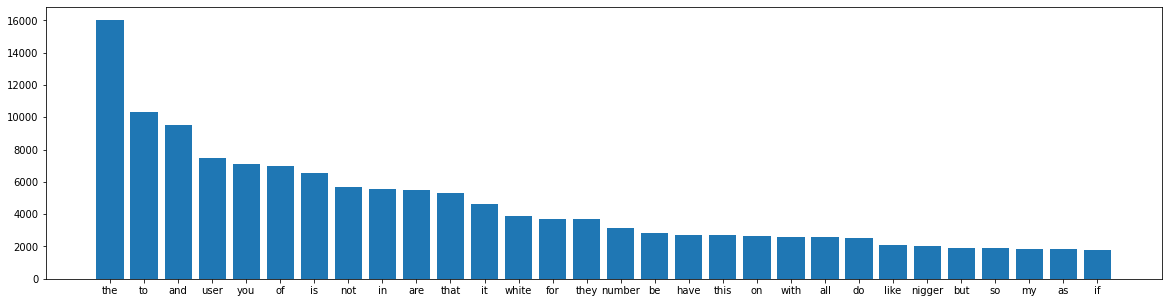

In [12]:
plt.figure(figsize = (20,5))
plt.bar(common_words[:30,0], np.array(common_words[:30,1], dtype = np.dtype(int)))

In [13]:
def get_top_n_profanity_words(corpus, profanity, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx])  for word, idx in vec.vocabulary_.items() if word in profanity]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

### In order to identify profanity we will be suing another dataset that contains extensive list of words that are offensive. You can download the dataset from this [link](https://data.world/natereed/banned-words-list/workspace/file?filename=swearWords.txt)

In [14]:
#https://data.world/natereed/banned-words-list/workspace/file?filename=swearWords.txt
with open("/content/drive/MyDrive/Datasets/profanity.txt") as f:
    profanity = [p.strip() for p in f.readlines()]

In [15]:
common_profanity_words = get_top_n_profanity_words(df.text, profanity)
common_profanity_words = np.array(common_profanity_words)

### In the below figure we can see the most common offensive words in the posts

<BarContainer object of 30 artists>

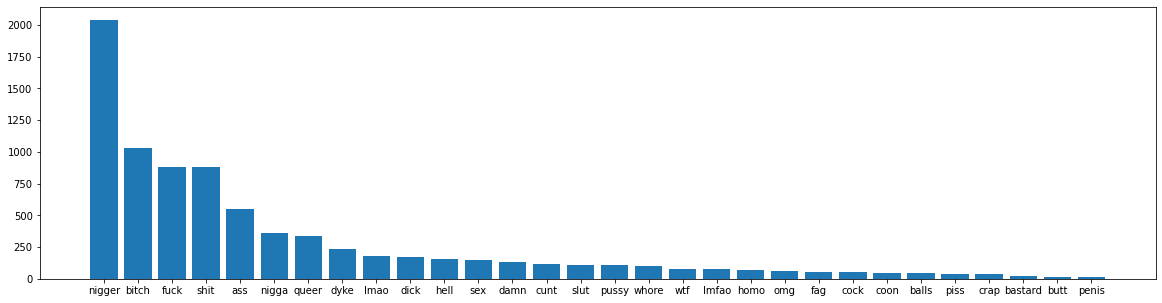

In [16]:
plt.figure(figsize = (20,5))
plt.bar(common_profanity_words[:30,0], np.array(common_profanity_words[:30,1], dtype = np.dtype(int)))

### We are creating final lable column that combines all the posts that are either offensive or contains hateful speech

In [17]:
index = [df.loc[df.text == " ".join(x)].index.values[0] for x in  df.text.str.split() for y in x if y in profanity ]

In [18]:
df["profanity"] = np.zeros(df.shape[0])

In [19]:
df.loc[index, ["profanity"]] = 1

In [20]:
df.profanity.sum()

6020.0

In [21]:
df.shape

(20148, 14)

In [22]:
df["label"] = np.zeros(df.shape[0])
df.loc[df.final_label == "toxic",["label"]]= 1
df.loc[df.profanity == 1,["label"]]= 1

In [23]:
df.label.sum(), len(df)

(13333.0, 20148)

### As you can see we have 13333.0 out of the total 20148 posts that are either hateful or offensive

### Below we are sampling the dataset to create train and test samples fro training our model

In [24]:
df = df.sample(frac=1).reset_index(drop=True)

In [25]:
n = len(df)

In [26]:
train_split = .8*n
train_examples = df.loc[:train_split] 
test_examples = df.loc[train_split:] 

In [27]:
train_examples.to_csv("train.csv")
test_examples.to_csv("test.csv")


# Building our own Keras text classifer Model

In [28]:
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier

import os

### We first need to create word emmbeddings for the entire dataset to convert sentences into their corresponding word vectors. For this we use the Keras Tokenizer.

In [29]:
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(train_examples.text)

X_train = tokenizer.texts_to_sequences(train_examples.text)
X_test = tokenizer.texts_to_sequences(test_examples.text)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

# printing the actual text along with their corresponding word vectors
print(train_examples.text[2])
print(X_train[2])

joaquin phoenix interpretation is majestic i was moved by him ❤️
[6878, 2673, 4976, 9, 8752, 5, 39, 1729, 42, 133, 2377]


In [30]:
# maximum length of each post
maxlen = 100

# padding the text to maintain uniformity in length
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

#word vector after padding
print(X_train[0, :])

[1387 4974 3635 4975   77   22   27  714    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


### Creating the Keras text classification model

In [31]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# compiling the model with binary_crossentropy loss function
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           1269800   
_________________________________________________________________
flatten (Flatten)            (None, 5000)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                50010     
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 1,319,821
Trainable params: 1,319,821
Non-trainable params: 0
_________________________________________________________________


### Training the model for 20 epochs 

In [32]:
history = model.fit(X_train, train_examples.label,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test, test_examples.label),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, train_examples.label, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, test_examples.label, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Epoch 1/20
1612/1612 [==============================] - 21s 12ms/step - loss: 0.6450 - accuracy: 0.6598 - val_loss: 0.4739 - val_accuracy: 0.7453
Epoch 2/20
1612/1612 [==============================] - 19s 12ms/step - loss: 0.4036 - accuracy: 0.8094 - val_loss: 0.4340 - val_accuracy: 0.7813
Epoch 3/20
1612/1612 [==============================] - 19s 11ms/step - loss: 0.2172 - accuracy: 0.9237 - val_loss: 0.5223 - val_accuracy: 0.7692
Epoch 4/20
1612/1612 [==============================] - 20s 12ms/step - loss: 0.0969 - accuracy: 0.9740 - val_loss: 0.6599 - val_accuracy: 0.7689
Epoch 5/20
1612/1612 [==============================] - 20s 12ms/step - loss: 0.0589 - accuracy: 0.9868 - val_loss: 0.8865 - val_accuracy: 0.7722
Epoch 6/20
1612/1612 [==============================] - 20s 12ms/step - loss: 0.0390 - accuracy: 0.9891 - val_loss: 1.0147 - val_accuracy: 0.7645
Epoch 7/20
1612/1612 [==============================] - 19s 12ms/step - loss: 0.0310 - accuracy: 0.9922 - val_loss: 1.3559 -

### Plotting the train, test loss and accuracy

In [33]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Test acc')
    plt.title('Training and test accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Test loss')
    plt.title('Training and test loss')
    plt.legend()

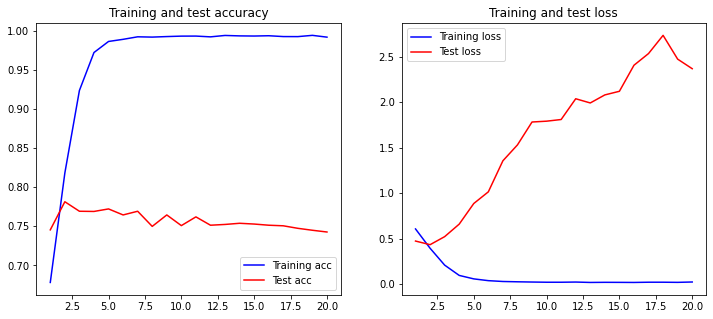

In [34]:
plot_history(history)

## Saving the trained model as a tflite model for using it to build a Mobile application

In [35]:
import tensorflow as tf
import json

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model) # providing the keras trained model
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpadgdcsjn/assets


### Saving the vocab file 

In [36]:
with open( 'word_dict.json' , 'w' ) as file:
	json.dump( tokenizer.word_index , file )

# References


1.   Mathew, Binny, et al. "HateXplain: A Benchmark Dataset for Explainable Hate Speech Detection." arXiv preprint arXiv:2012.10289 (2020).

2.   https://data.world/natereed/banned-words-list/workspace/file?filename=swearWords.txt

3.   https://www.tensorflow.org/lite/convert

4.   https://www.kaggle.com/sanikamal/text-classification-with-python-and-keras#What-Is-a-Word-Embedding?



